## Imports

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn import tree
from pickle import dump
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from utils import get_classifier_metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings('ignore')

## PASO 1: Cargamos nuestros datos

### Decision Tree

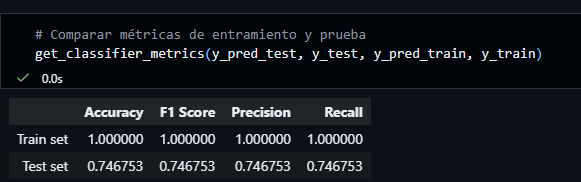

### Random Forest

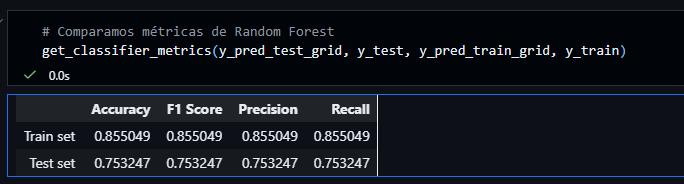

## PASO 2: Modelado


### Modelado

In [16]:
xgb = XGBClassifier(n_estimators=200,
                    learning_rate=0.1,
                    random_state=42,
                    use_label_encoder=False,
                    eval_metric='mlogloss')
ada = AdaBoostClassifier(n_estimators=200,
                         learning_rate=0.1,
                         random_state=42)
gb = GradientBoostingClassifier(n_estimators=200,
                                learning_rate=0.1,
                                random_state=42)
lgb = LGBMClassifier(n_estimators=200,
                     learning_rate=0.1,
                     random_state=42)


### Entrenamiento

In [17]:
ada.fit(X_train, y_train)

,estimator,None
,n_estimators,200
,learning_rate,0.1
,algorithm,'deprecated'
,random_state,42


In [18]:
gb.fit(X_train, y_train)

,loss,'log_loss'
,learning_rate,0.1
,n_estimators,200
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [19]:
xgb.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


In [20]:
lgb.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 214, number of negative: 400
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 666
[LightGBM] [Info] Number of data points in the train set: 614, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348534 -> initscore=-0.625489
[LightGBM] [Info] Start training from score -0.625489
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,200
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


## PASO 3: Prediccion

In [21]:
ada_y_pred_test = ada.predict(X_test)
gb_y_pred_test = gb.predict(X_test)
xgb_y_pred_test =  xgb.predict(X_test)
lgb_y_pred_test = lgb.predict(X_test)

ada_y_pred_train = ada.predict(X_train)
gb_y_pred_train = gb.predict(X_train)
xbg_y_pred_train = xgb.predict(X_train)
lgb_y_pred_train = lgb.predict(X_train)

In [22]:
accuracy_train =(accuracy_score(y_train, ada_y_pred_train),
                accuracy_score(y_train, gb_y_pred_train),
                accuracy_score(y_train, xbg_y_pred_train),
                accuracy_score(y_train, lgb_y_pred_train))

accuracy_test = (accuracy_score(y_test, ada_y_pred_test),
                accuracy_score(y_test, gb_y_pred_test),
                accuracy_score(y_test, xgb_y_pred_test),
                accuracy_score(y_test, lgb_y_pred_test))

accuracy= pd.DataFrame(data=[accuracy_train, accuracy_test],
                       columns=['AdaBoost', 'Gradient Boosting', 'XGBoost', 'LightGBM'],
                       index=['Train Accuracy', 'Test Accuracy'])

accuracy                     

,AdaBoost,Gradient Boosting,XGBoost,LightGBM
Train Accuracy,0.794788,0.982085,1.000000,1.000000
Test Accuracy,0.759740,0.759740,0.753247,0.714286


## PASO 4: Comparacion

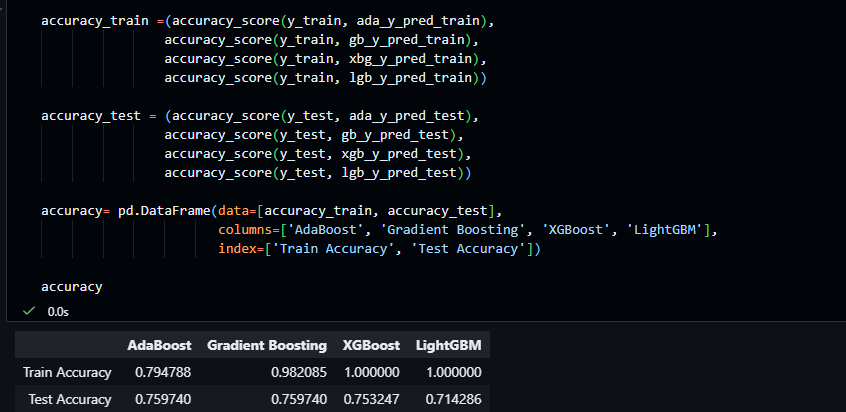

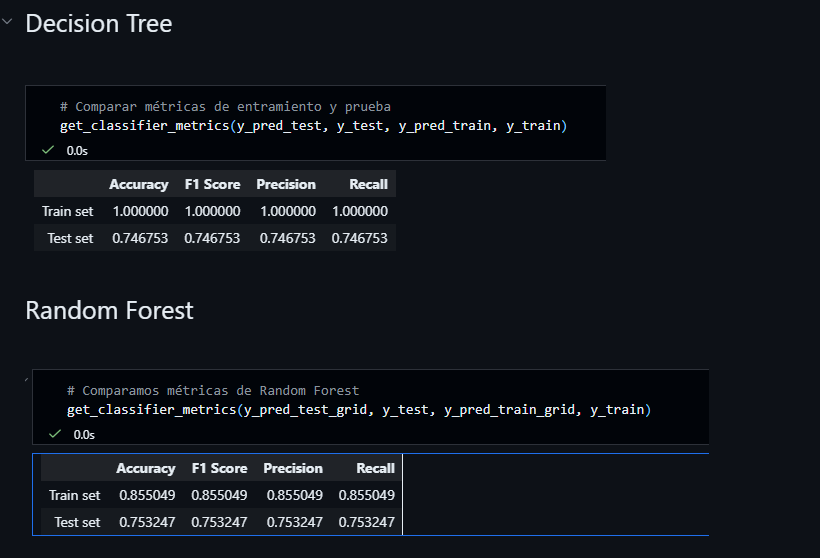

## Conclusión

Podemos observar que:

1. Decision Tree: Obtenemos valores perfectos en el Train set, esto se puede dar debido a que hay que mejorar el EDA o a que nuestra data es muy pequeña y no tenemos errores a la hora de entrenar el modelo, por otra parte, en el Test obtenemos valores más realistas obteniendo un 74% de efectividad.

2. Random Forest: Obtenemos mejores valores en comparación con el Decision Tree, donde obtenemos un porcentaje de efectividad de 85% en el entrenamiento y un 75% en nuestro test.

3. Boosting: Aqui podemos observar que tenemos valores variantes, esto se puede dar debido a que en nuestro EDA tenemos una data pequeña o que hace falta un analisis más profundo para mejorar nuestros datos de entrenamiento ya que, nos esta dando en el modelo XGBoost un 100% de efectividad y de igual forma en el LightBoost, lo cúal esta mal ya que no puede ser de 100% esta efectividad, ya que tenemos un claro overfitting. Por otro lado conseguimos un 79% en el AdaBoost y un 98% en GradientBoost aún así debemos tener cuidado con este porcentaje en el GradientBoost ya que puede tener un overfitting.
A su vez tenemos unos resultados creibles en nuestros datos de Test ya que obtenemos un 75% en la mayoria de los modelados exeptuando el LightBoost donde obtenemos un 71%.